## Install and import libraries

In [ ]:
pip install h5py typing-extensions wheel

In [ ]:
pip install diffrax equinox jax optax scipy cvxpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.7.1 which is incompatible.


In [ ]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate

# import equinox.experimental as eqxe
import jax.tree_util as jtu
import functools as ft

import cvxpy as cp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and pre-process data

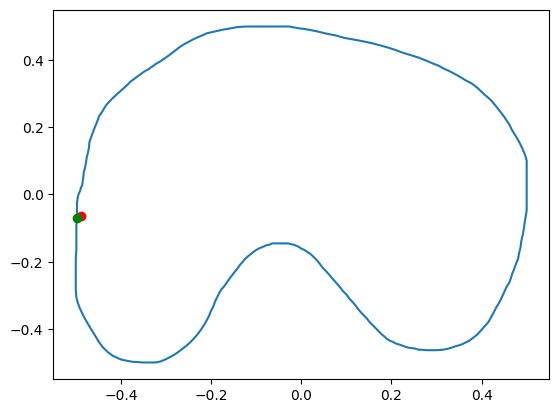

In [ ]:
# Reading data from text file

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

flag = None
traj_all = []
traj_c = 0

# file_name = '/content/drive/MyDrive/Colab Notebooks/trajs_loop_1.txt'

file_name = '/content/drive/MyDrive/Colab Notebooks/trajs_loop_4.txt'

# file_name = '/content/drive/MyDrive/Colab Notebooks/trajs_TB.txt'

f = open(file_name, 'r')
data_text = f.readlines()
for i in data_text:
    if i == 'New trajectory\n':
        flag = 'new'
        if traj_c > 0:
            traj_all.append(traj)
        traj_c += 1
        continue
    if flag == 'new':
        traj = np.fromstring(i, dtype=float, sep=' ').reshape((1, 2))
        flag = 'old'
        continue
    if flag == 'old':
        traj = np.concatenate((traj, np.fromstring(i, dtype=float, sep=' ').reshape((1, 2))))
traj_all.append(traj)

traj_all_norm = []
ts_norm = []
scaler = MinMaxScaler(feature_range=(-0.5,0.5))
scaler_all = []
for i in range(len(traj_all)):
    scaler.fit(traj_all[i])
    scaler_all.append(scaler)
    ysti = scaler.transform(traj_all[i])
    traj_all_norm.append(ysti)
    ts_norm.append(jnp.linspace(0,1,num=ysti.shape[0]))
    # scaler.fit(ts.reshape(-1, 1))
    # tst = scaler.transform(ts.reshape(-1, 1))
    # tst = tst.reshape(-1, )

dim = traj.shape[1]

nsamples = 300

data_aug = 0

traj_all_process = jnp.zeros((traj_c + data_aug, nsamples, dim))

seed = 1385

key = jax.random.PRNGKey(seed)

key_trajs = jax.random.split(key, num=traj_c + data_aug)

for i in range(traj_c + data_aug):
  key_dim = jax.random.split(key_trajs[i], num=dim)
  for j in range(dim):
    f = interpolate.interp1d(ts_norm[i], traj_all_norm[i][:, j])
    ts_new = np.linspace(0, 1, nsamples)
    range_traj = max(traj_all_norm[i][:, j]) - min(traj_all_norm[i][:, j])
    scale = 0
    traj_new = f(ts_new) + jax.random.uniform(key_dim[j], shape=ts_new.shape, minval=-scale*range_traj, maxval=scale*range_traj)
    traj_all_process = traj_all_process.at[i, :, j].set(traj_new)

traj_d = jnp.diff(traj_all_process, axis=1)
traj_d = jnp.concatenate((traj_d, jnp.zeros((traj_c + data_aug, 1, dim))), axis=1)
traj_d_all = jnp.concatenate((traj_all_process, traj_d), axis=2)

for i in range(traj_c + data_aug):
    plt.plot(traj_all_process[i][0, 0], traj_all_process[i][0, 1], 'ro')
    plt.plot(traj_all_process[i][:, 0], traj_all_process[i][:, 1])
    plt.plot(traj_all_process[i][-1, 0], traj_all_process[i][-1, 1], 'go')

## Define models

In [ ]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initializer = jnn.initializers.orthogonal()
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )
        model_key = key
        key_weights = jrandom.split(model_key, depth+1)

        for i in range(depth+1):
          where = lambda m: m.layers[i].weight
          shape = self.mlp.layers[i].weight.shape
          self.mlp = eqx.tree_at(where, self.mlp, replace=initializer(key_weights[i], shape, dtype = jnp.float32))

    def __call__(self, t, y, args):

        # return self.mlp(y)

        # model_with_sn = apply_sn(self.mlp)

        return self.mlp(y)

In [ ]:
class Funcd(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=2*data_size,
            out_size=2*data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, yd, args):

        # return self.mlp(y)
        return self.mlp(yd)

In [ ]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, yd0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=yd0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [ ]:
class NeuralODEd(eqx.Module):
    func: Funcd

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Funcd(data_size, width_size, depth, key=key)

    def __call__(self, ts, yd0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=yd0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

## Data loader

In [ ]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

## Train

In [ ]:
def main(
    dataset_size=int(1),
    batch_size=int(1),
    lr_strategy=(3e-3,),
    steps_strategy=(3000,),
    length_strategy=(1,),
    width_size=64,
    depth=3,
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)

    # training data

    ys = traj_all_process[:dataset_size]
    ys_all = traj_d_all[:dataset_size]
    ts = ts_new

    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_d_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        # f = lambda z: model.func(_, z, _)
        # y_dot_pred = jax.vmap(jax.vmap(f, in_axes = (0, 0)), in_axes=(None, 0))(ti, yi)
        loss = jnp.mean((yi - y_d_pred) ** 2)
        # loss = jnp.mean((y_dot_pred - yi_dot)**2)
        return loss

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        decay_scheduler = optax.cosine_decay_schedule(lr, decay_steps=steps, alpha=0.95)
        # decay_scheduler = optax.piecewise_constant_schedule(init_value=lr, boundaries_and_scales={int(steps*0.25):0.5, int(steps*0.5):0.5, int(steps*0.75):0.5})
        # decay_scheduler = optax.exponential_decay(init_value=lr, transition_steps=steps, decay_rate=0.98, transition_begin=int(steps*0.25), staircase=False)
        # decay_scheduler = optax.linear_schedule(init_value=lr, end_value=0.001*lr, transition_steps=steps, transition_begin=int(steps*0.25))
        optim = optax.adabelief(learning_rate=decay_scheduler)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]\
        for step in range(steps):
          start = time.time()
          loss, model, opt_state = make_step(_ts, _ys, model, opt_state)
          end = time.time()
          if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")
        ## Batches
        # for step, (yi,) in zip(
        #     range(steps), dataloader((_ys,), batch_size, key=loader_key)
        # ):
        #     start = time.time()
        #     loss, model, opt_state = make_step(_ts, yi, model, opt_state)
        #     end = time.time()
        #     if (step % print_every) == 0 or step == steps - 1:
        #         print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    # if plot:
    #     plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
    #     plt.plot(ts, ys[0, :, 1], c="dodgerblue")
    #     model_y = model(ts, ys[0, 0])
    #     plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
    #     plt.plot(ts, model_y[:, 1], c="crimson")
    #     plt.legend()
    #     plt.tight_layout()
    #     plt.savefig("neural_ode.png")
    #     plt.show()

    return ts, ys, model

In [ ]:
ts, ys, model = main()

Step: 0, Loss: 0.16623590886592865, Computation time: 36.33220076560974
Step: 100, Loss: 0.01276081521064043, Computation time: 0.04297351837158203
Step: 200, Loss: 0.0073961918242275715, Computation time: 0.05570650100708008
Step: 300, Loss: 0.006191136781126261, Computation time: 0.046311378479003906
Step: 400, Loss: 0.0056028589606285095, Computation time: 0.04382061958312988
Step: 500, Loss: 0.005241157952696085, Computation time: 0.052610158920288086
Step: 600, Loss: 0.005305142141878605, Computation time: 0.04823803901672363
Step: 700, Loss: 0.004925031680613756, Computation time: 0.049596548080444336
Step: 800, Loss: 0.004594692029058933, Computation time: 0.059358835220336914
Step: 900, Loss: 0.004315481521189213, Computation time: 0.0493011474609375
Step: 1000, Loss: 0.003895584726706147, Computation time: 0.04902482032775879
Step: 1100, Loss: 0.0034781107679009438, Computation time: 0.06412863731384277
Step: 1200, Loss: 0.003408529097214341, Computation time: 0.04571199417114

## Plot predicted trajectories

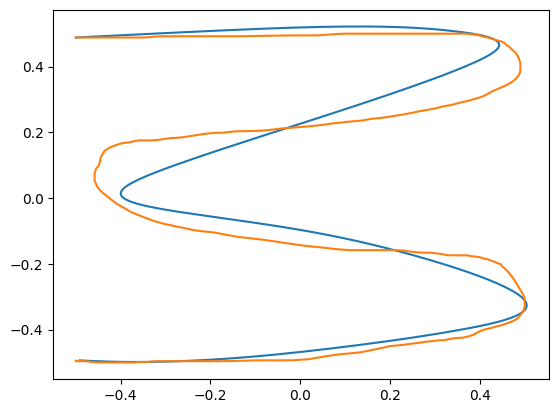

In [ ]:
indx = 0
# traj_d_all = traj_spirals_d_all
model_y = model_load_TB(0.93*ts, traj_all_process[indx, 0, :])
plt.plot(model_y[:,0], model_y[:,1], label="Model")
# indx = 6
# model_y = model(ts, traj_all_process[indx, 0, :])
# plt.plot(model_y[:,0], model_y[:,1], label="Model")
plt.plot(traj_all_process[indx, :, 0], traj_all_process[indx, :, 1], label="Real")
# plt.legend()
# plt.tight_layout()

## Save the model

In [ ]:
file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_loop_3_spur_att_checkpoint.eqx"
eqx.tree_serialise_leaves(file_name, model)

## Load the model

In [ ]:
# file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_LR_hand_drawn_checkpoint.eqx"
# ys = traj_LR_all_process
# ts = ts_LR_new
# _, length_size, data_size = ys.shape
# width_size=64
# depth=3
# seed=1000
# key = jrandom.PRNGKey(seed)
# data_key, model_key, loader_key = jrandom.split(key, 3)
# model1 = NeuralODE(data_size, width_size, depth, key=model_key)
# model_load_LR = eqx.tree_deserialise_leaves(file_name, model1)

file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_loop_3_spur_att_checkpoint.eqx"
ys = traj_all_process
ts = ts_new
_, length_size, data_size = ys.shape
width_size=64
depth=3
seed=1000
key = jrandom.PRNGKey(seed)
data_key, model_key, loader_key = jrandom.split(key, 3)
model1 = NeuralODE(data_size, width_size, depth, key=model_key)
model_load_TB = eqx.tree_deserialise_leaves(file_name, model1)

# file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_hand_drawn/Wiping_TB_hand_drawn_spur_att_checkpoint.eqx"
# ys = traj_all_process
# ts = ts_new
# _, length_size, data_size = ys.shape
# width_size=32
# depth=2
# seed=1000
# key = jrandom.PRNGKey(seed)
# data_key, model_key, loader_key = jrandom.split(key, 3)
# model1 = NeuralODE(data_size, width_size, depth, key=model_key)
# model_load_TB = eqx.tree_deserialise_leaves(file_name, model1)

# file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_hand_drawn/Wiping_spirals_hand_drawn_checkpoint.eqx"
# ys = traj_all_process
# ts = ts_new
# _, length_size, data_size = ys.shape
# width_size=128
# depth=5
# seed=1000
# key = jrandom.PRNGKey(seed)
# data_key, model_key, loader_key = jrandom.split(key, 3)
# model1 = NeuralODEd(data_size, width_size, depth, key=model_key)
# model_load_spirals = eqx.tree_deserialise_leaves(file_name, model1)

## Libraries and functions for vector field visualization

In [ ]:
# !apt install cm-super
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [ ]:
def streamQuiver(ax,sp,*args,spacing=None,n=5,**kwargs):
    """ Plot arrows from streamplot data
    The number of arrows per streamline is controlled either by `spacing` or by `n`.
    See `lines_to_arrows`.
    """
    def curve_coord(line=None):
        """ return curvilinear coordinate """
        x=line[:,0]
        y=line[:,1]
        s     = np.zeros(x.shape)
        s[1:] = np.sqrt((x[1:]-x[0:-1])**2+ (y[1:]-y[0:-1])**2)
        s     = np.cumsum(s)
        return s

    def curve_extract(line,spacing,offset=None):
        """ Extract points at equidistant space along a curve"""
        x=line[:,0]
        y=line[:,1]
        if offset is None:
            offset=spacing/2
        # Computing curvilinear length
        s = curve_coord(line)
        offset=np.mod(offset,s[-1]) # making sure we always get one point
        # New (equidistant) curvilinear coordinate
        sExtract=np.arange(offset,s[-1],spacing)
        # Interpolating based on new curvilinear coordinate
        xx=np.interp(sExtract,s,x);
        yy=np.interp(sExtract,s,y);
        return np.array([xx,yy]).T

    def seg_to_lines(seg):
        """ Convert a list of segments to a list of lines """
        def extract_continuous(i):
            x=[]
            y=[]
            # Special case, we have only 1 segment remaining:
            if i==len(seg)-1:
                x.append(seg[i][0,0])
                y.append(seg[i][0,1])
                x.append(seg[i][1,0])
                y.append(seg[i][1,1])
                return i,x,y
            # Looping on continuous segment
            while i<len(seg)-1:
                # Adding our start point
                x.append(seg[i][0,0])
                y.append(seg[i][0,1])
                # Checking whether next segment continues our line
                Continuous= all(seg[i][1,:]==seg[i+1][0,:])
                if not Continuous:
                    # We add our end point then
                    x.append(seg[i][1,0])
                    y.append(seg[i][1,1])
                    break
                elif i==len(seg)-2:
                    # we add the last segment
                    x.append(seg[i+1][0,0])
                    y.append(seg[i+1][0,1])
                    x.append(seg[i+1][1,0])
                    y.append(seg[i+1][1,1])
                i=i+1
            return i,x,y
        lines=[]
        i=0
        while i<len(seg):
            iEnd,x,y=extract_continuous(i)
            lines.append(np.array( [x,y] ).T)
            i=iEnd+1
        return lines

    def lines_to_arrows(lines,n=5,spacing=None,normalize=True):
        """ Extract "streamlines" arrows from a set of lines
        Either: `n` arrows per line
            or an arrow every `spacing` distance
        If `normalize` is true, the arrows have a unit length
        """
        if spacing is None:
            # if n is provided we estimate the spacing based on each curve lenght)
            spacing = [ curve_coord(l)[-1]/n for l in lines]
        try:
            len(spacing)
        except:
            spacing=[spacing]*len(lines)

        lines_s=[curve_extract(l,spacing=sp,offset=sp/2)         for l,sp in zip(lines,spacing)]
        lines_e=[curve_extract(l,spacing=sp,offset=sp/2+0.01*sp) for l,sp in zip(lines,spacing)]
        arrow_x  = [l[i,0] for l in lines_s for i in range(len(l))]
        arrow_y  = [l[i,1] for l in lines_s for i in range(len(l))]
        arrow_dx = [le[i,0]-ls[i,0] for ls,le in zip(lines_s,lines_e) for i in range(len(ls))]
        arrow_dy = [le[i,1]-ls[i,1] for ls,le in zip(lines_s,lines_e) for i in range(len(ls))]

        if normalize:
            dn = [ np.sqrt(ddx**2 + ddy**2) for ddx,ddy in zip(arrow_dx,arrow_dy)]
            arrow_dx = [ddx/ddn for ddx,ddn in zip(arrow_dx,dn)]
            arrow_dy = [ddy/ddn for ddy,ddn in zip(arrow_dy,dn)]
        return  arrow_x,arrow_y,arrow_dx,arrow_dy

    # --- Main body of streamQuiver
    # Extracting lines
    seg   = sp.lines.get_segments() # list of (2, 2) numpy arrays
    lines = seg_to_lines(seg)       # list of (N,2) numpy arrays
    # Convert lines to arrows
    ar_x, ar_y, ar_dx, ar_dy = lines_to_arrows(lines,spacing=spacing,n=n,normalize=True)
    # Plot arrows
    qv=ax.quiver(ar_x, ar_y, ar_dx, ar_dy, *args, angles='xy', **kwargs)
    return qv

# --- Example
# x = np.linspace(-1,1,100)
# y = np.linspace(-1,1,100)
# X,Y=np.meshgrid(x,y)
# u = -np.sin(np.arctan2(Y,X))
# v =  np.cos(np.arctan2(Y,X))

# xseed=np.linspace(0.1,1,4)

# fig=plt.figure()
# ax=fig.add_subplot(111)
# sp = ax.streamplot(x,y,u,v,color='plum',arrowstyle='-',start_points=np.array([xseed,xseed*0]).T,density=30)
# qv = streamQuiver(ax,sp,spacing=0.5, scale=60)
# plt.show()

## **Paper**: motion plan with disturbance illustration using predicted vector field and trajectories

(-0.6, 0.6)

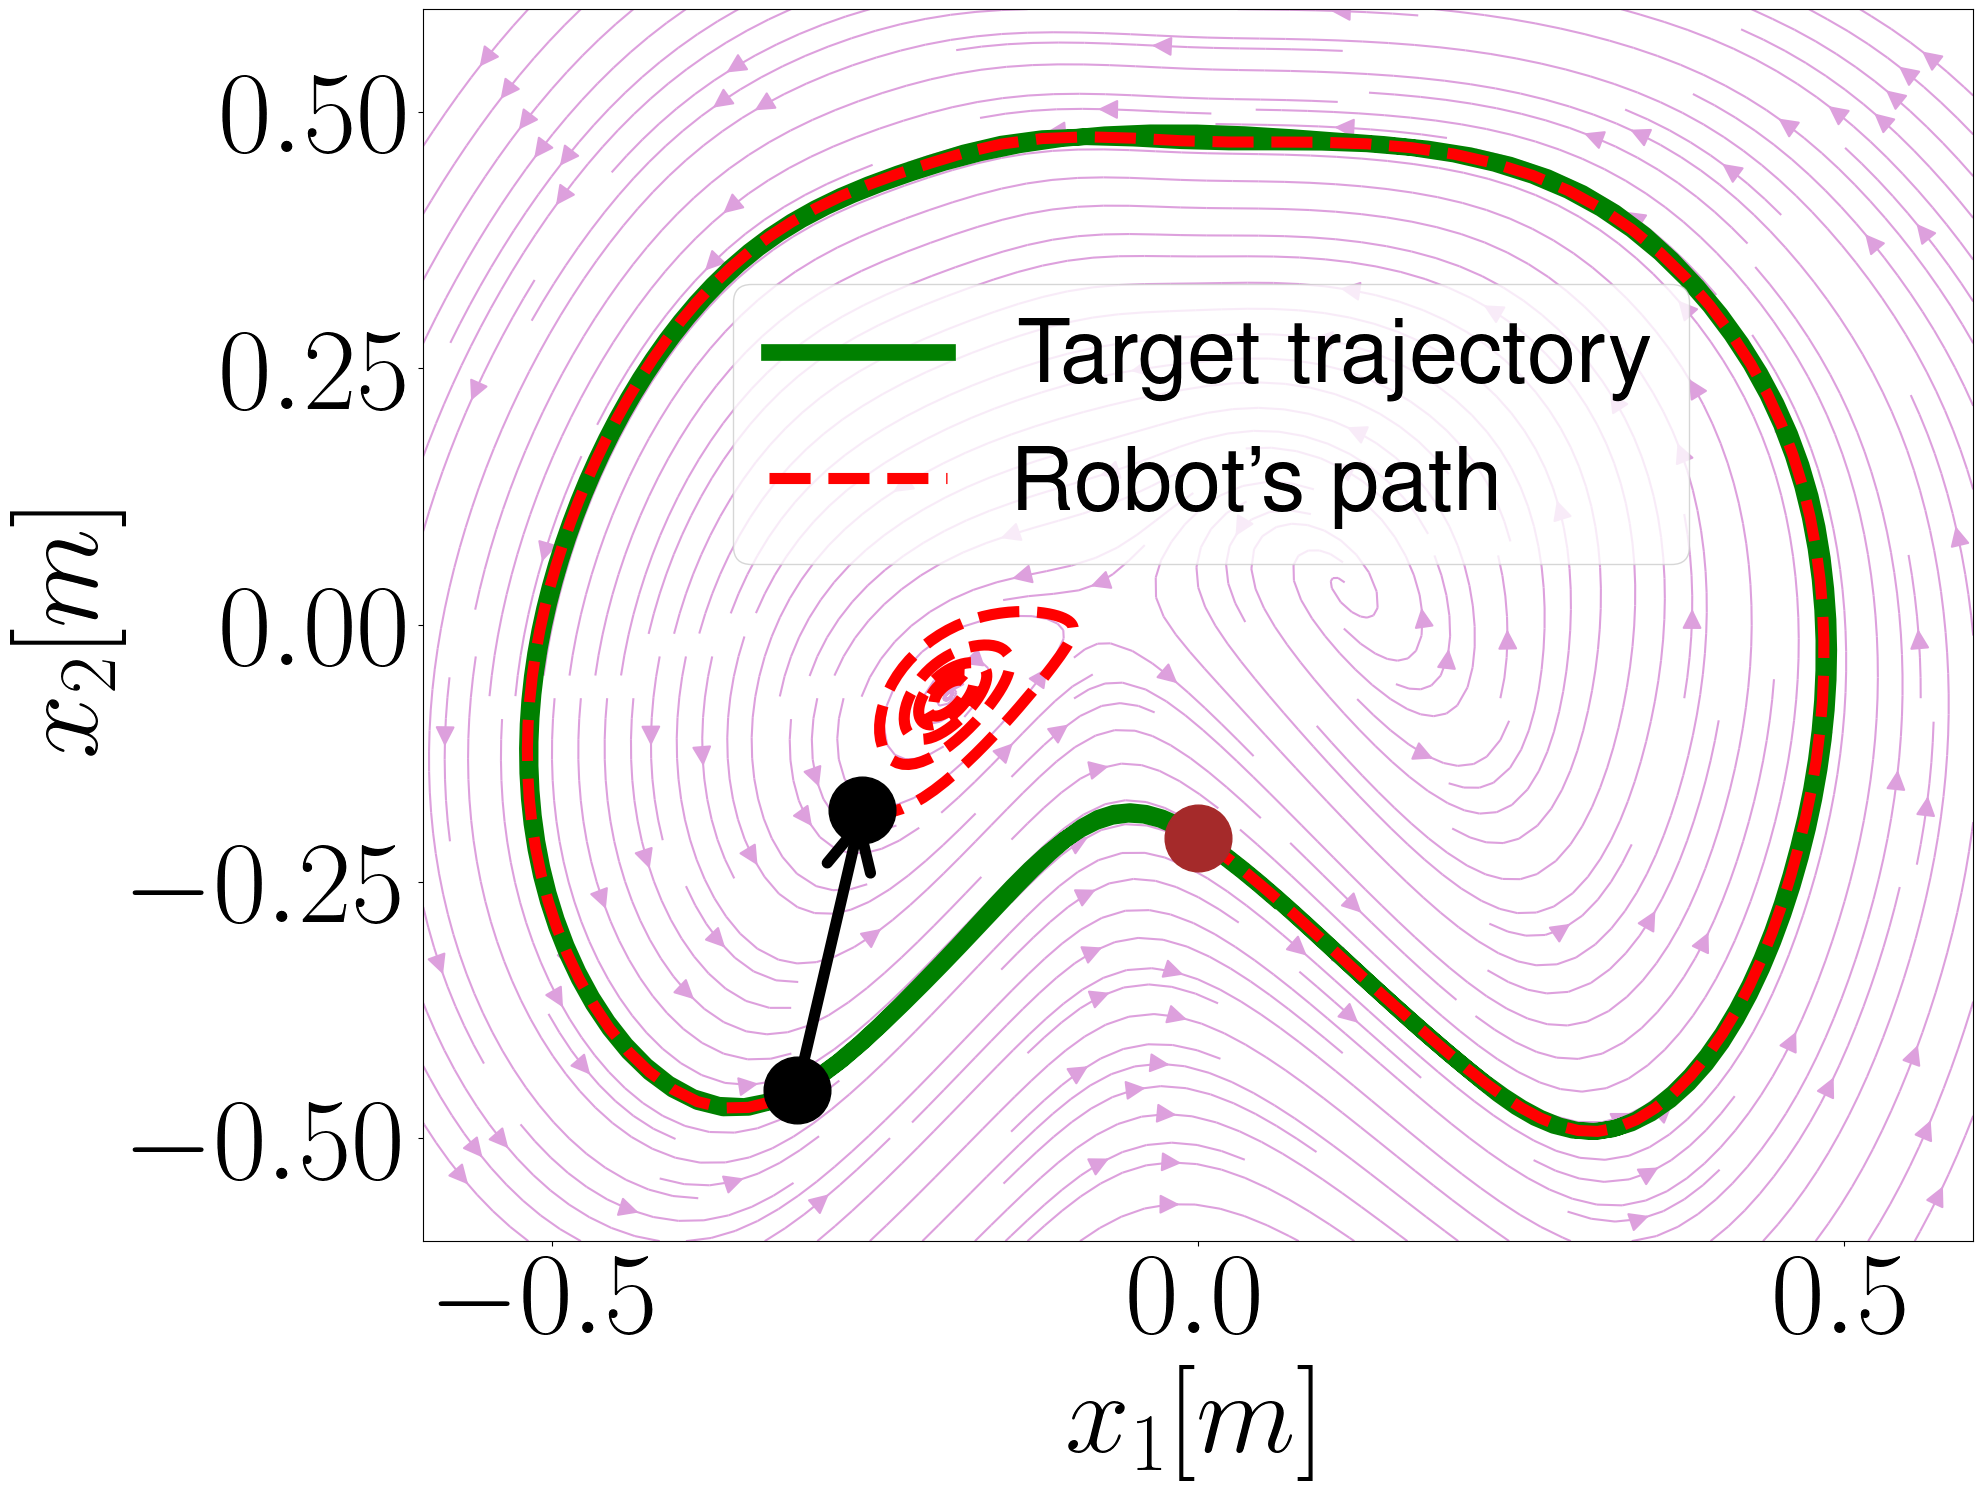

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
font = {'size': 84}
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

xmin = -0.6
xmax = 0.6
ymin = -0.6
ymax = 0.6
(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(20,16))
ys = traj_all_process
indx = 0
ts = ts_new
model_load = model_load_TB
f = lambda z : model_load.func(_, z, _)
x, y = np.meshgrid(np.linspace(xmin, xmax, 50),
                   np.linspace(ymin, ymax, 50))
xyz_vec = np.hstack((x.reshape((x.size, -1)), y.reshape((y.size, -1))))
uvw_vec = jax.vmap(f, in_axes=0)(xyz_vec)
proj_uvw = uvw_vec
u = proj_uvw[:, 0].reshape((x.shape[0], x.shape[0]))
v = proj_uvw[:, 1].reshape((y.shape[0], y.shape[0]))
# x, y = np.meshgrid(np.linspace(0.2, 0.8, 50),
#                    np.linspace(-0.6, 0.6, 50))
# plt.quiver(x[:, :, 0], y[:, :, 0], u[:, :, 0], v[:, :, 0], scale = 10, color='g', label='Learnt vector field')
# sp = ax.streamplot(x, y, u ,v, arrowstyle='-', density=3, linewidth=None, color='plum', arrowsize=3)
# streamQuiver(ax, sp, n=5, color='plum', width = 0.01)
sp = ax.streamplot(x, y, u ,v, density=2, color='plum', arrowsize=3)
start = jnp.array([0,-0.207]) # wiping loop 3 spurr_att
# start = traj_all_process[0][0]
model_y = model_load(2*ts, start)
# dist_point = jnp.array([-0.8, -0.3]) # 2nd wiping task converging to goal
# dist_point = jnp.array([-0.65, -0.2]) # 1st wiping task spurr_att
dist_point = jnp.array([-0.26,-0.18]) # wiping loop 3 spurr_att
dist_indx = 125
model_y_dist = model_load(2*ts, dist_point)
g_indx = -1
# ax.annotate('Start', xy=(model_y[0, 0], model_y[0, 1]), xytext=(-50, 25), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
# ax.annotate('Goal', xy=(model_y[g_indx, 0], model_y[g_indx, 1]), xytext=(-30, 0), textcoords='offset points', horizontalalignment='right', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
# ax.annotate('Disturbance', xy=(model_y[dist_indx, 0], model_y[dist_indx, 1]), xytext=(-25, 5), textcoords='offset points', horizontalalignment='right', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
ax.plot(model_y[:, 0], model_y[:, 1], c="green", linewidth='12', label="Target trajectory")
ax.plot(model_y[:dist_indx, 0], model_y[:dist_indx, 1], c="red", linewidth='8', linestyle='--', label="Robot's path")
# ax.plot(xall[:, 0], xall[:, 1], c="red", linewidth='8', linestyle='--')
ax.plot(model_y_dist[:, 0], model_y_dist[:, 1], c="red", linewidth='8', linestyle='--')
ax.plot(start[0], start[1], 'o', color='brown', markersize=48)
# ax.plot(model_y[-1, 0], model_y[-1, 1], marker="o", markersize=48, c="darkblue")
ax.plot(model_y[dist_indx, 0], model_y[dist_indx,1], 'o', color='black', markersize=48)
ax.plot(dist_point[0], dist_point[1], 'o', color='black', markersize=48)
# ax.plot(traj_all_process[0, :, 0], traj_all_process[1,:, 1], c="green", linewidth='5', label="Target trajectory")
## Obstacle
# xc = np.array([-0.27, -0.15])
# r = 0.13
# circle = plt.Circle((xc), r, color='dodgerblue')
# ax.add_artist(circle)
# # ax.plot(xall[:, 0], xall[:, 1], c="red", linewidth='4', linestyle='--')
# ax.plot(model_y[:dist_indx, 0], model_y[:dist_indx, 1], c="red", linewidth='4', linestyle='--', label="Robot's path")
# # ax.plot(model_y[:dist_indx, 0], model_y[:dist_indx, 1], c="red", linewidth='4', linestyle='--', label="Robot's path")
# ax.plot(model_y[0, 0], model_y[0, 1], marker="o", markersize=18, c="saddlebrown")
# # plt.plot(np.array([model_y[130, 0], model_y_dist[0, 0]]), np.array([model_y[130, 1], model_y_dist[0, 1]]), c="green", linewidth='2', label="Disturbance", linestyle='--')
# # plt.arrow(model_y[130, 0], model_y[130, 1], model_y_dist[0, 0] - model_y[130, 0], model_y_dist[0, 1] - model_y[130, 1])
ax.annotate("", xy=(dist_point[0], dist_point[1]), xytext=(model_y[dist_indx, 0], model_y[dist_indx, 1]), arrowprops=dict(mutation_scale=80, arrowstyle="->", linewidth=8)) # Disturbance Arrow
# alpha = 7
# alpha_n = 12
# # ax.annotate("", xy=(alpha_n*(model_y_dist[1, 0]-model_y_dist[0, 0]) + model_y_dist[0, 0], alpha_n*(model_y_dist[1, 1]-model_y_dist[0, 1]) + model_y_dist[0, 1]),
# #             xytext=(model_y_dist[0, 0], model_y_dist[0, 1]), arrowprops=dict(arrowstyle="->", linewidth=4, color='red')) # Arrow
# # ax.annotate("", xy=(alpha*(xall[1, 0] - xall[0, 0]) + xall[0, 0], alpha*(xall[1, 1] - xall[0, 1]) + xall[1, 1]), xytext=(xall[0, 0], xall[0, 1]),
# #             arrowprops=dict(arrowstyle="->", linewidth=4, color='blue')) # Arrow
# ax.plot(model_y[dist_indx, 0], model_y[dist_indx, 1], marker="o", markersize=18, c="black")
# ax.plot(dist_point[0], dist_point[1], marker="o", markersize=18, c="black")
# # plt.plot(traj_all_process[indx, 0, 0], traj_all_process[indx, 0, 1], 'ro')
# # plt.plot(traj_all_process[indx, -1, 0], traj_all_process[indx, -1, 1], 'go')
# # ax.plot(ys[indx, :, 0], ys[indx, :, 1], ys[indx, :, 2], c='red', label='Demonstration')
ax.legend(loc=[0.2, 0.55], fontsize='64')
ax.set_xlabel(r"$x_1 [m]$")
ax.set_ylabel(r"$x_2 [m]$")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
# # ax.set_xlabel('x')
# plt.tight_layout()
# # ax.show()

## Animation of motion with disturbance

In [ ]:
pip install celluloid

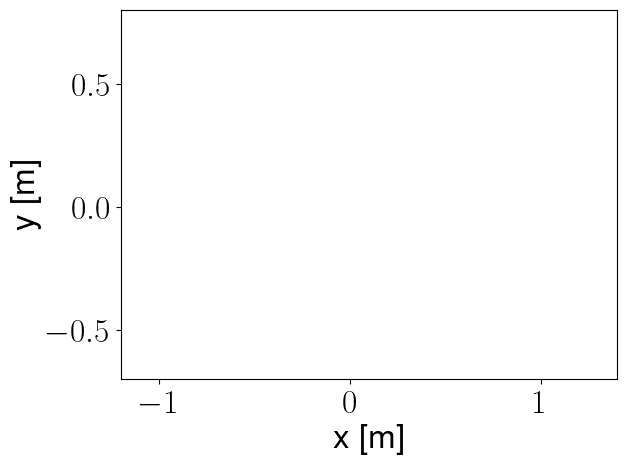

In [ ]:
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
%matplotlib inline

font = {'size': 24}
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

(fig, ax) = plt.subplots()

# ax.set(xlim=(-60, 20), ylim=(-15, 25))
ax.set_ylabel('y [m]')
ax.set_xlabel('x [m]')
# ax.get_xaxis().set_label_coords(0.5, 0.12)

actual_path = jnp.concatenate((model_y[:dist_indx], model_y_dist))

# Initiate camera
camera = Camera(fig)

pause_f = 0

# Create individual frames
for j in range(1, actual_path.shape[0]):

    sp = ax.streamplot(x, y, u ,v, density=1, color='plum', arrowsize=1)

    ax.plot(model_y[:, 0], model_y[:, 1], c="green", linewidth='2', label="Target trajectory")

    if j >= 125:
      if pause_f == 0:
        pause = 0
        pause_f = 1
      ax.annotate("", xy=(model_y_dist[0, 0], model_y_dist[0, 1]), xytext=(model_y[dist_indx, 0], model_y[dist_indx, 1]),
            arrowprops=dict(arrowstyle="->", linewidth=2)) # Disturbance Arrow
      ax.plot(model_y[dist_indx, 0], model_y[dist_indx, 1], marker="o", c="black")
      ax.plot(dist_point[0], dist_point[1], marker="o", c="black")
      if pause < 5:
        pause += 1
        j = 125

    # Projectile's trajectory
    x_path = actual_path[0:j, 0]
    y_path = actual_path[0:j, 1]

    # Show Projectile's location
    ax.plot(x_path[-1], y_path[-1], marker='o', markersize=12, markeredgecolor='r', markerfacecolor='r')

    # Show Projectile's trajectory
    ax.plot(x_path, y_path, color='red', lw=2, linestyle='--')

    # Capture frame
    camera.snap()

# Create animation
anim = camera.animate(interval = 300, repeat = True, repeat_delay = 5000)

# Inline display
HTML(anim.to_html5_video())

In [ ]:
# Create animation
anim = camera.animate(interval = 50, repeat = True, repeat_delay = 5000)

# Inline display
HTML(anim.to_html5_video())

# Stability: CLF-QP implementation

In [ ]:
indx = 0
ys = traj_all_process
model_load = model_load_TB
f = lambda z : model_load.func(_, z, _)
xref = model_load(0.93*ts, start)
# x = ys[indx,0,:]
x = dist_point
r = jnp.array([0.05])
xall = jnp.expand_dims(x, axis=0)

N = 5

vopt_all = []

t0i = 0
t1i = ts[1] - ts[0]
dti = t1i

for i in range(dist_indx, int(1*len(ts))-1):

  # if(i==66):
  #   # indx = indx_angle
  #   # model_load = model_load_angle
  #   x = jnp.array([-0.4, -0.25])

  # if(i==600):
  #   indx = indx_spoon
  #   model_load = model_load_spoon
  #   ys = posn_spoon
  #   f = lambda z : model_load.func(_, z, _)

  x_t=np.asarray(x)

  # xref = np.asarray(ys[indx,i,:])

  # closest_ind = np.argmin(np.linalg.norm(xref - x_t, axis=1))

  # go_to_ind = np.clip(closest_ind + N, 0, xref.shape[0])

  # xref_t = xref[go_to_ind]

  xref_t = xref[i]

  tsi = jnp.array([0, dti])
  # tsi_d = jnp.array([ts[i], ts[i+1]])

  alpha_h = 35
  gamma = 0.1
  lambda_v = 0

  Q = np.eye(x_t.shape[0])
  G = 2*((x_t-xref_t).T)
  fx_t = np.asarray(f(x_t))
  fxref_t = np.asarray(f(xref_t))
  # h = -2*(((x_t-xref_t).T)@(fx_t - fxref_t)) + alpha_h*(-(((x_t-xref_t).T)@(x_t-xref_t)) + r**2) # CBF
  h = -2*(((x_t-xref_t).T)@(fx_t - fxref_t)) - alpha_h*((((x_t-xref_t).T)@(x_t-xref_t))) # CLF
  # h = -(alpha_h*(-(((x1-xref_t).T)@(x1-xref_t)) + r**2) + gamma)

  # h = alpha_h*(((x1-xref_t).T)@(x1-xref_t))+gamma

  # h = alpha_h*(-(((x1-xref_t).T)@(x1-xref_t)) + r**2) + gamma

  vopt = cp.Variable(x_t.shape[0])
  prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q)  + lambda_v*cp.pos(G @ vopt - h)),
                  [G @ vopt <= h])

  prob.solve()

  # x = jnp.asarray(x1)

  # f1 = lambda t, z, args : model_load.func(t, z, _) + vopt.value
  # solution = diffrax.diffeqsolve(
  #     diffrax.ODETerm(f1),
  #     diffrax.Tsit5(),
  #     t0=ts[i],
  #     t1=ts[i+1],
  #     dt0=dti,
  #     y0=x,
  #     stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
  #     saveat=diffrax.SaveAt(ts=tsi_d),
  # )

  f1 = lambda z : model_load.func(_, z,_) + vopt.value

  # vopt_all.append(np.linalg.norm(vopt.value))

  xnext = f1(x)*dti + x

  # xnext = solution.ys[-1,:]

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)

  x = xnext

  if(i%10==0):
    print(f"Time: {i}, Position: {x}")

Time: 130, Position: [-0.5761148  -0.17629921]
Time: 140, Position: [-0.4259204  -0.15877281]
Time: 150, Position: [-0.22858799 -0.13223319]
Time: 160, Position: [-0.04421166 -0.12614946]
Time: 170, Position: [ 0.12303443 -0.15116568]
Time: 180, Position: [ 0.2698486 -0.1945808]
Time: 190, Position: [ 0.39149067 -0.24538887]
Time: 200, Position: [ 0.47283593 -0.2989728 ]
Time: 210, Position: [ 0.49383035 -0.33771107]
Time: 220, Position: [ 0.4364025  -0.37814242]
Time: 230, Position: [ 0.3009074  -0.41451594]
Time: 240, Position: [ 0.14179525 -0.44553494]
Time: 250, Position: [-0.01271157 -0.4705815 ]
Time: 260, Position: [-0.15119001 -0.48778874]
Time: 270, Position: [-0.2694013  -0.49674407]
Time: 280, Position: [-0.36742282 -0.49906373]
Time: 290, Position: [-0.4483789  -0.49686736]


# CBF for obstacle avoidance

In [ ]:
indx = 3
ys = traj_TB_all_process
ts = ts_TB_new
model_load = model_load_TB
f = lambda t, z : model_load.func(t, z, _)
x = ys[indx,0,:]
xall = jnp.expand_dims(ys[indx,0,:], axis=0)
xref = model_load(ts, ys[indx, 0, :])

xc = jnp.array([0.6, 0.6])
r = jnp.array([0.1])

rho = 0.05

for i in range(len(ts)-1):

  x1=np.asarray(x)

  t0i = 0
  t1i = ts[i+1] - ts[i]
  dti = t1i

  tsi = jnp.array([0, dti])

  xref_t = np.asarray(xref[i, :])

  Q = np.eye(x1.shape[0])
  G = -2*((x1-xc).T)
  fx1 = np.asarray(f(ts[i], x1))
  h = 2*(((x1-xc).T)@fx1) + 100*((((x1-xc).T)@(x1-xc)) - r**2)


  alpha_v = 10
  gamma = 10
  lambda_v = 100

  h = alpha_v*(x1-xref_t).T @ (x1-xref_t) + gamma

  vopt = cp.Variable(x1.shape[0])
  prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q) + lambda_v*cp.pos(2*vopt.T @ (x1 -xref_t) + h)),
                  [G @ vopt <= h])

  prob.solve()

  #x = jnp.asarray(x1)

  # f1 = lambda t, z, args : model_load.func(_, z, _) + vopt.value
  # solution = diffrax.diffeqsolve(
  #     diffrax.ODETerm(f1),
  #     diffrax.Tsit5(),
  #     t0=t0i,
  #     t1=t1i,
  #     dt0=dti,
  #     y0=x,
  #     stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
  #     saveat=diffrax.SaveAt(ts=tsi),
  # )

  f1 = lambda t, z : model_load.func(t, z,_) + vopt.value

  xnext = f1(ts[i], x)*dti + x

  #xnext = solution.ys[-1,:]

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)

  x = xnext

  if(i%10==0):
    print(f"Time: {i}, Position: {x}")

Time: 0, Position: [0.00890764 1.0019754 ]
Time: 10, Position: [0.16004848 1.0187225 ]
Time: 20, Position: [0.3868303 1.031693 ]
Time: 30, Position: [0.64655554 1.0361493 ]
Time: 40, Position: [0.87933785 1.0241715 ]
Time: 50, Position: [1.0174003  0.98702234]
Time: 60, Position: [0.9752749 0.9056895]
Time: 70, Position: [0.73184025 0.8245227 ]
Time: 80, Position: [0.4412522  0.76645356]
Time: 90, Position: [0.21440294 0.7260105 ]
Time: 100, Position: [0.1067826  0.69338864]
Time: 110, Position: [0.11632609 0.6589898 ]
Time: 120, Position: [0.2393202  0.62248766]
Time: 130, Position: [0.45464903 0.5884583 ]
Time: 140, Position: [0.59938025 0.49121064]
Time: 150, Position: [0.87561995 0.502126  ]
Time: 160, Position: [0.9536034  0.44467908]
Time: 170, Position: [0.88654006 0.3739732 ]
Time: 180, Position: [0.70127445 0.30127287]
Time: 190, Position: [0.4757527  0.24020788]
Time: 200, Position: [0.2648418  0.19335674]
Time: 210, Position: [0.11883148 0.15960027]
Time: 220, Position: [0.0

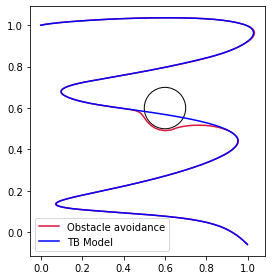

In [ ]:
figure, axes = plt.subplots()
plt.plot(xall[:, 0], xall[:, 1], c="crimson", label="Obstacle avoidance")
model_load = model_load_TB
model_y = model_load(ts, traj_TB_all_process[indx, 0])
plt.plot(model_y[:, 0], model_y[:, 1], c="blue", label="TB Model")
circle = plt.Circle((xc), r, fill = False)
axes.set_aspect(1)
axes.add_artist(circle)
plt.tight_layout()
plt.legend()